#Résultat du GSCNN

Connexion au drive, chargement des librairies et importation des codes python

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

!pip install tensorboardX
!pip install scipy==1.2.0
!pip install torch-encoding
!pip install ninja
!pip install fastcluster

import sys
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import skimage.measure
import time
import numpy as np

sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/GSCNN-master')

import apply
import visualize

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).



Définition d'une fonction d'affichage

In [ ]:
import matplotlib.cm as cm

def plot_graphic(image, cmap = 'Paired', vmin = False): 
  plt.figure(figsize=(20, 10), dpi=80)
  lut = len(np.unique(image))
  if lut>30:
    cmap = cm.get_cmap(cmap, lut=lut)
  if type(vmin) is tuple:
    plt.imshow(np.array(np.flipud(image)), cmap=cmap, vmin=vmin[0], vmax=vmin[1])
  else : 
    plt.imshow(np.array(np.flipud(image)), cmap=cmap)
  plt.axis('off')
  plt.show()

Fonctions pour mettre une image à jour, afficher les résultats et faire le clutering

In [ ]:
from PIL import Image 
from train import args
import transforms.transforms as extended_transforms
import torchvision.transforms as standard_transforms
import apply

#emplacement ou mettre les fichiers temporaires
path_s = '/content/gdrive/My Drive/mira_project'

def numpy_pil(img, flip=True,norm=True):
  """
  change numpy to pil for the network with normlaization
  in : img
  out : img PIL
  """
  if type(norm) is not tuple: 
    img = (img-img.min())/(img.max()-img.min())
  else:
    img = (img-norm[0])/(norm[1]-norm[0])

  img = (img[:,:]*255).astype(np.uint8)
  
  if flip:
    img = np.flipud(img)
  
  img = Image.fromarray(img)

  return img

def transform_im(img, mean_std = ([0.157, 0.157, 0.157], [0.106, 0.106, 0.106])):
  """
  normlalized pil to mean_normalized torch  
  in : img (pil normalized)
       means_std : ([0.157, 0.157, 0.157], [0.106, 0.106, 0.106])
  out : img torch shape[2,3,x,y]
  """

  trans = standard_transforms.Compose([extended_transforms.ToRGB(),
                                      standard_transforms.ToTensor(), #change PIL image H*X*C to torch C*H*W [0. -1.]
                                      standard_transforms.Normalize(*mean_std)])

  img = trans(img)
  data = torch.unsqueeze(img, 0)
  data = data.repeat(2, 1 ,1, 1)
  
  return data

def plotting_all(img, mean_std):
  #preapare data
  data = transform_im(img, mean_std)

  #afficher l'image d'origine
  plot_graphic(data[0,0], cmap = 'jet')
  
  #calculer les sorties des Aspp
  apply.assp_all([data], net, path_s) 
  data_aspp = apply.load_npy(path_s+'_assp.npy')

  #obtenir les sorties de segmentation
  data_seg = apply.load_npy(path_s+'_seg.npy')
  data_edge = apply.load_npy(path_s+'_edge.npy')

  #calculer les sorties des gates
  apply.gate_all([data], net, path_s)
  data_g3 = apply.load_npy(path_s+'_gate1.npy')
  data_g4 = apply.load_npy(path_s+'_gate2.npy')
  data_g7 = apply.load_npy(path_s+'_gate3.npy')

  #afficher la segmentation de l'algorithme
  plot_graphic(data_seg[0], cmap = 'Paired')

  #afficher les bordures trouvées
  plot_graphic(data_edge[0], cmap = 'Greys')
  
  #afficher les gates
  plot_graphic(data_g3[0], cmap = 'Spectral')
  plot_graphic(data_g4[0], cmap = 'Spectral')
  plot_graphic(data_g7[0], cmap = 'Spectral')

def it_hclus(net, data, mini=6, maxi=16, res=1, lim=0.95, border =16):
  """
  Fonction pour réaliser le clustering sur la sortie de l'ASPP
  """   
  vals, seg_out, edge_out = apply.aspp_output(net, data)
  _, x, y = visualize.prepare_data2cluster(vals.cpu()[0], border=border, res=res)
  
  for i in range(mini,maxi):
  #hierarchical
    start = time.time()
    results = visualize.hclustering_output(vals.cpu()[0], n_clusters=i, distance_threshold=None, border = border, res=res, lim = lim)
    end = time.time()
    tim = end-start

    print(i)
    plot_graphic(results.reshape(x, y), cmap = 'tab20')

Chargement du modèle pré-entrainé

In [ ]:
#Charger le modèle préentrainé
args.snapshot = '/content/gdrive/My Drive/illustration_result/12_t_oda_v_f45_1_1_0_1_lr0002_bc/best_epoch_675_mean-iu_0.68698.pth'
net = apply.load_trained_model(args)

07-08 19:40:19.591 Using Per Image based weighted loss
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
07-08 19:40:19.598 Using Cross Entropy Loss


num class :  3


/content/gdrive/My Drive/Colab Notebooks/GSCNN-master/network/mynn.py:30: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)
07-08 19:40:27.794 Model params = 137.3M
07-08 19:40:27.835 Loading weights from model /content/gdrive/My Drive/illustration_result/12_t_oda_v_f45_1_1_0_1_lr0002_bc/best_epoch_675_mean-iu_0.68698.pth
07-08 19:40:42.897 Load Compelete


Visualisation de l'entrainement

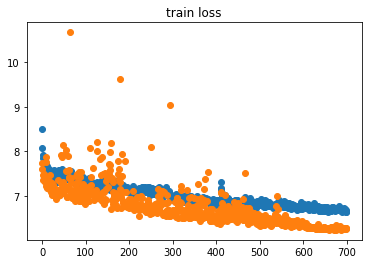

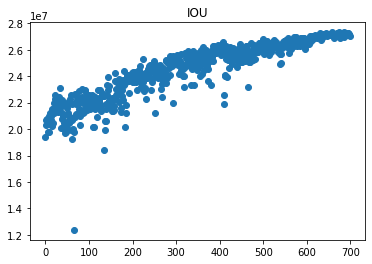

In [ ]:
import pickle as pkl
import pandas as pd

path = '/content/gdrive/My Drive/illustration_result/12_t_oda_v_f45_1_1_0_1_lr0002_bc//history_df.pkl'

with open(path, 'rb') as f:
  data = pkl.load(f)   

#data = pd.concat([data2, data])
train_loss = data['train_loss']
validate = data['validate']
IOU = data['IOU']
ran = np.arange(data.shape[0])
plt.scatter(ran, train_loss)
plt.scatter(ran, validate)
plt.title('train loss')
plt.show()

plt.scatter(ran, [i[0,0] + i[1,1] + i[2,2] for i in data['IOU']])
plt.title('IOU')
plt.show()

##Données du modèle 3D d'origine

Charger l'image d'origine, le modèle utilisé et afficher les résultats

In [ ]:
#changer args.dataset pour les données entrainées
args.dataset = 'syntmag'

#valeurs médiane et éacrt type pour le jeu de données
mean_std = ([0.157, 0.157, 0.157], [0.106, 0.106, 0.106])

#Charger l'image d'origine
img = np.load('gdrive/My Drive/mira_project/original.npy')
img = numpy_pil(img[0,:,:,0], flip=False)

#Afficher les résultas 
plotting_all(img, mean_std)


Output hidden; open in https://colab.research.google.com to view.

Réaliser le clustering à différents clusters

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


number of PCA : 27
8


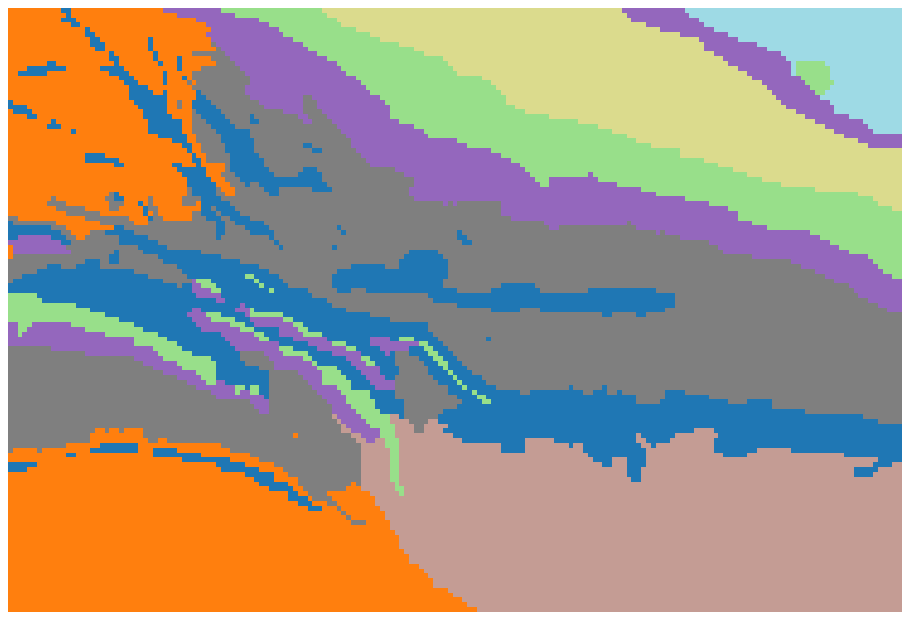

number of PCA : 27
9


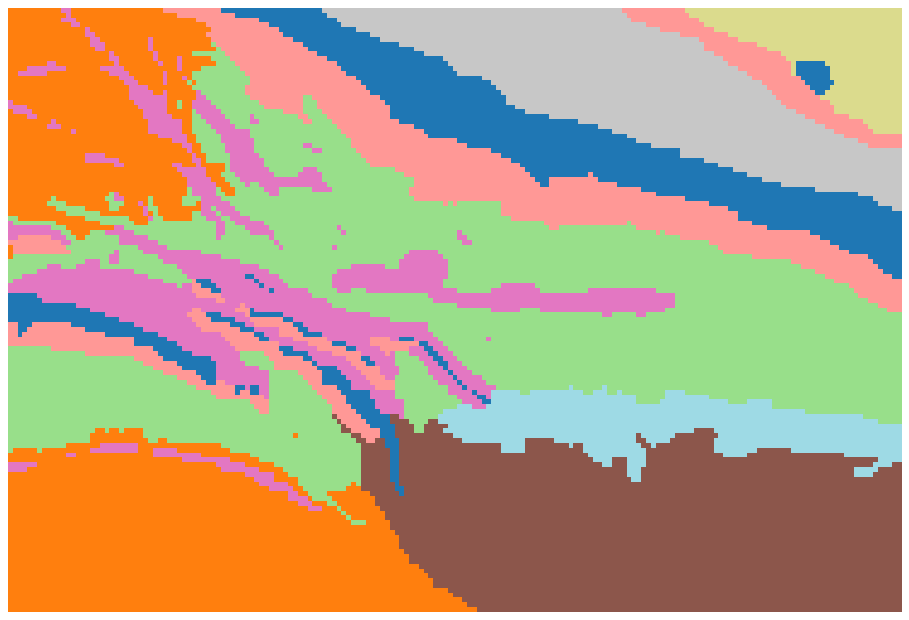

number of PCA : 27
10


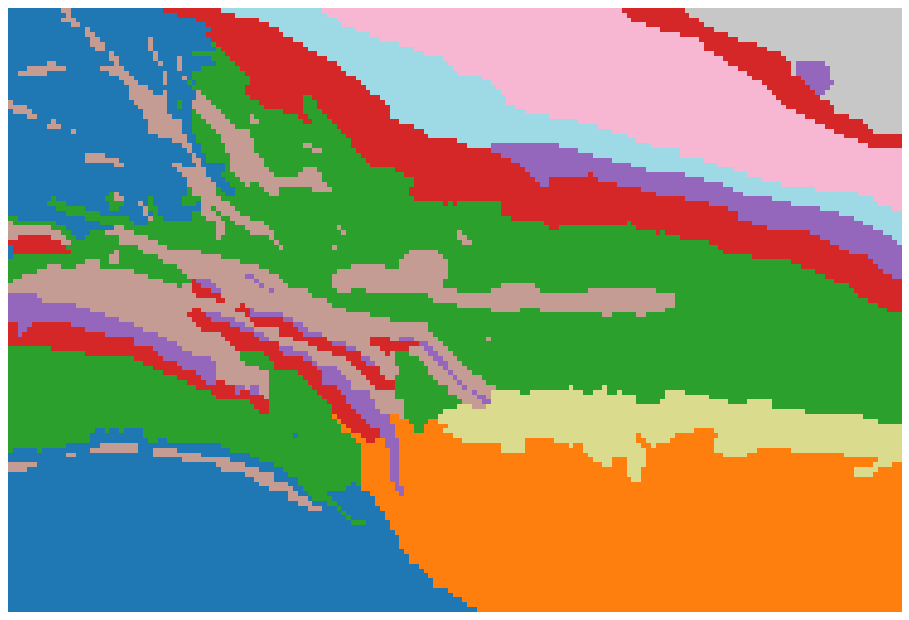

In [ ]:
data = transform_im(img, mean_std)
it_hclus(net, data, mini=8, maxi=11, res=1, lim=0.95, border =16)

##Résultats sur les données réelles

Données réelles à l'ouest

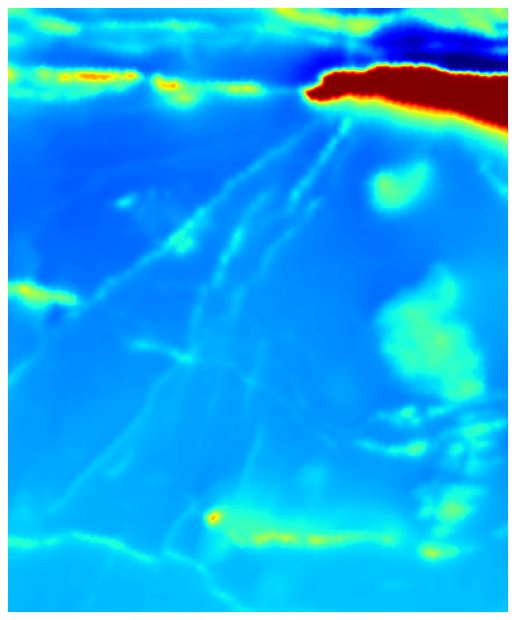

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


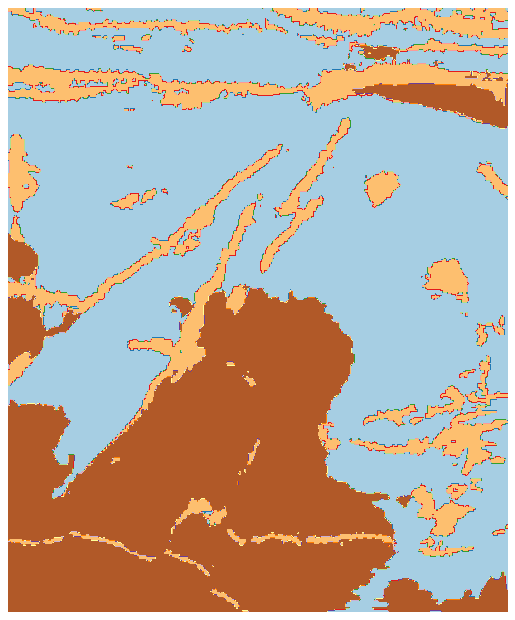

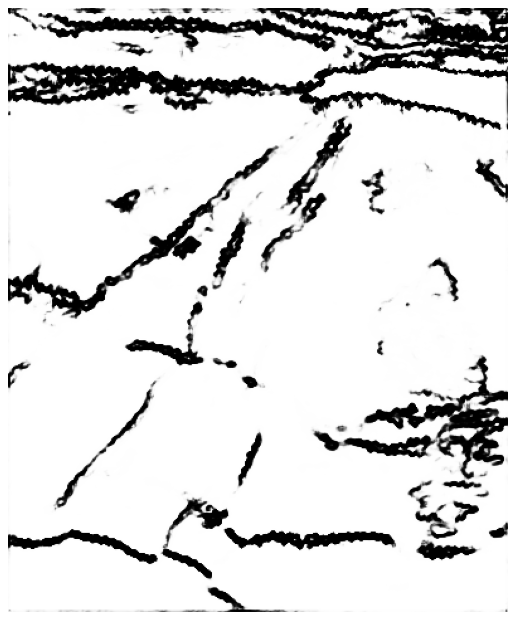

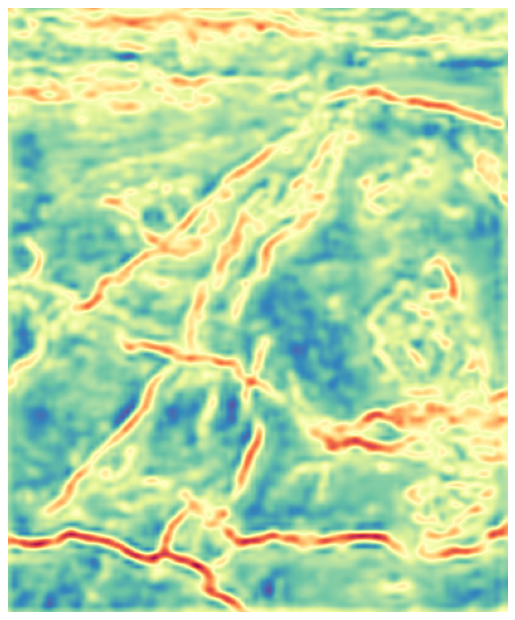

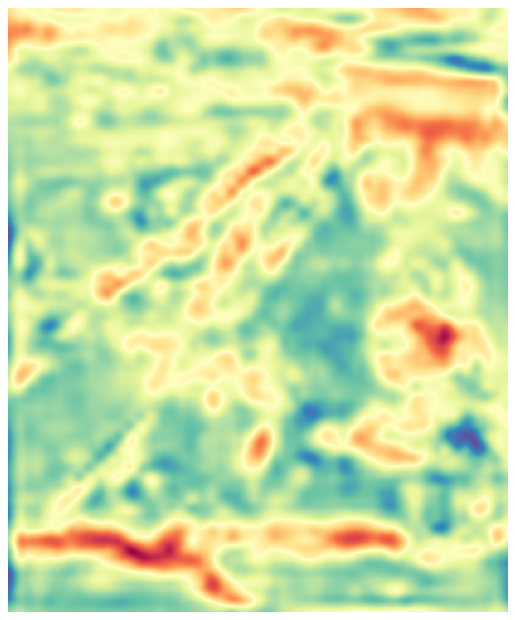

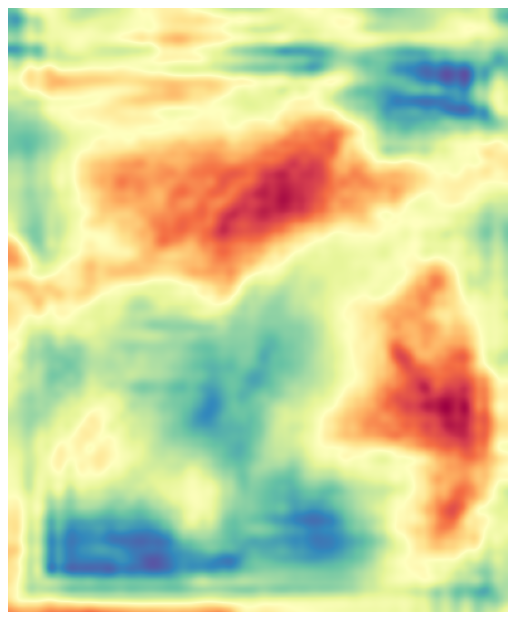

number of PCA : 32
8


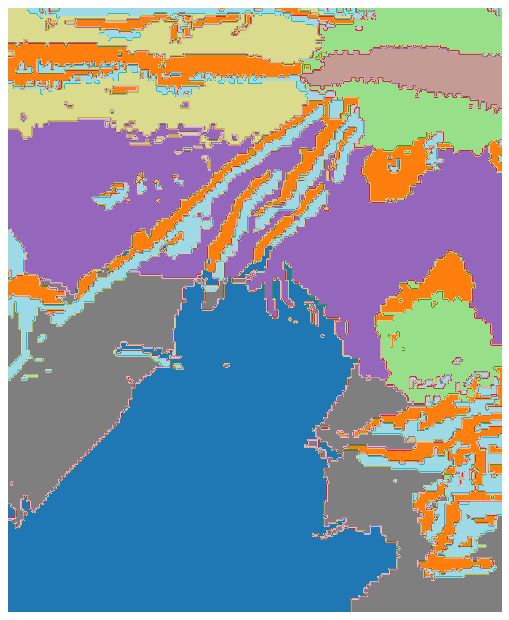

number of PCA : 32
9


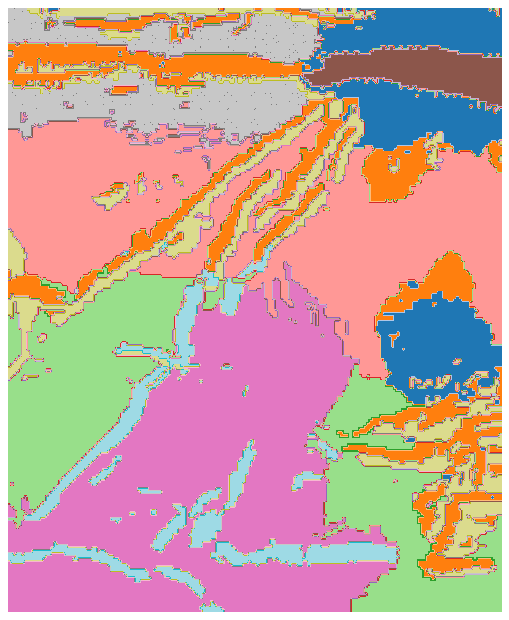

number of PCA : 32
10


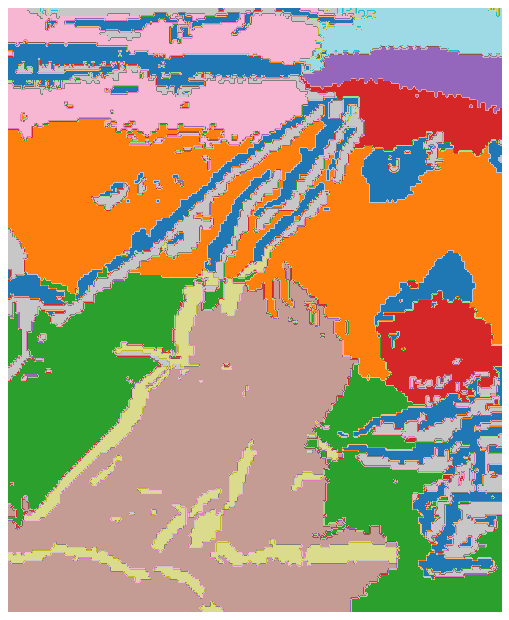

In [ ]:
sys.path.insert(0, '/content/gdrive/My Drive/preprocessing/a_utils')
from z_utils import open_pkl

#définition de constantes
mean_std = ([0.300, 0.300, 0.300], [0.135, 0.135, 0.135])
path = '/content/gdrive/My Drive/preprocessing/z_data/gscnn/'
cutoff = (-750, 1500)

#charger les données
data_ouest = open_pkl(path+'mag_similar_ouest_pp.pkl')
img = numpy_pil(data_ouest, flip=True, norm=cutoff)

#afficher les résultats
plotting_all(img, mean_std)
data = transform_im(img, mean_std)
it_hclus(net, data, mini=8, maxi=11, res=1, lim=0.95, border =16)


Données réelles à l'est

In [ ]:
#chargement des données 
data_est = open_pkl(path+'mag_similar_est_pp.pkl')
img = numpy_pil(data_est, flip=True, norm=cutoff)

#afficher les résultats
plotting_all(img, mean_std)
data = transform_im(img, mean_std)
it_hclus(net, data, mini=12, maxi=15, res=1, lim=0.95, border =16)

Output hidden; open in https://colab.research.google.com to view.

Données réelles centrales

In [ ]:
#Chargement des données
data_mod = open_pkl(path+'mag_model_pp.pkl')
img = numpy_pil(data_mod, flip=True, norm=cutoff)

#afficher les résultats
plotting_all(img, mean_std)
data = transform_im(img, mean_std)
it_hclus(net, data, mini=9, maxi=12, res=1, lim=0.95, border =16)

Output hidden; open in https://colab.research.google.com to view.

## Transfer Learning sur le Grenville

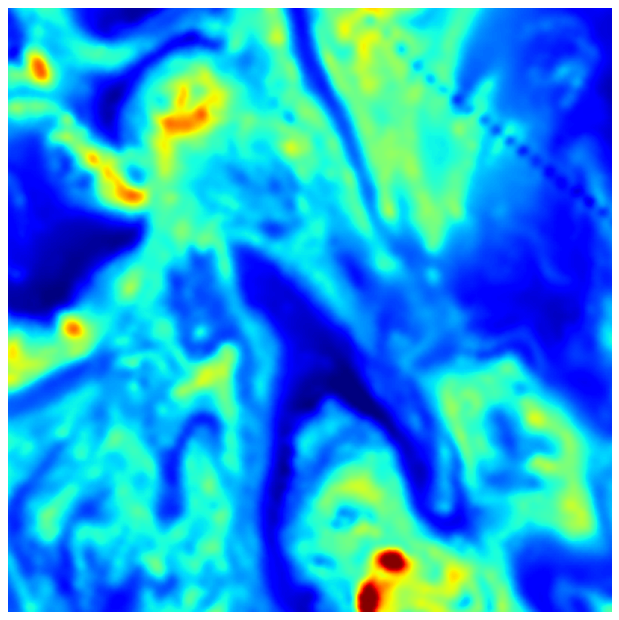

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


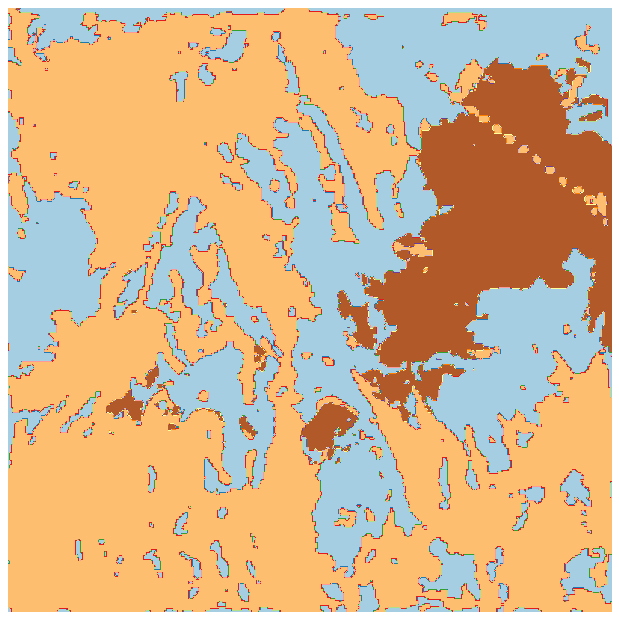

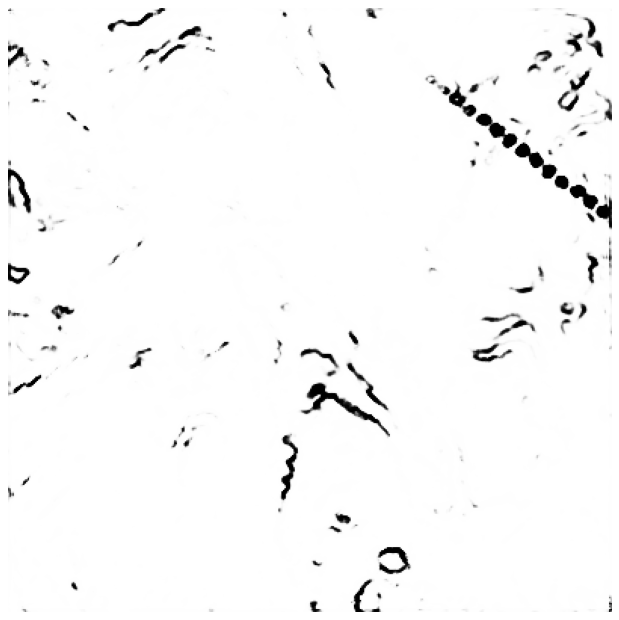

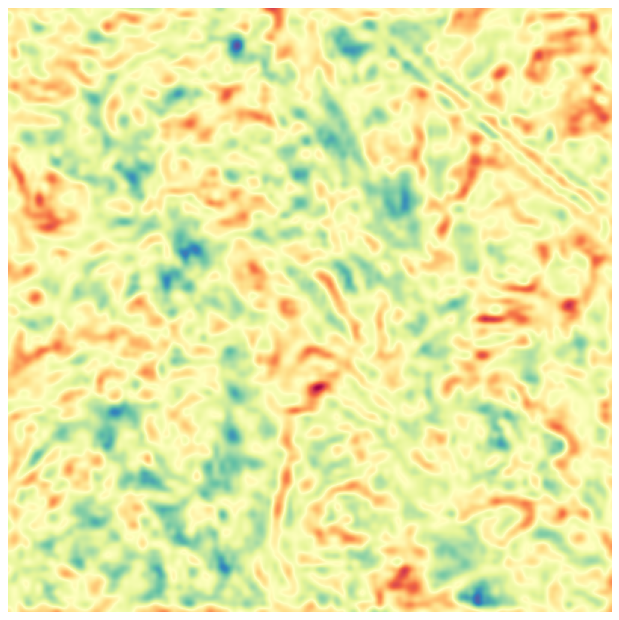

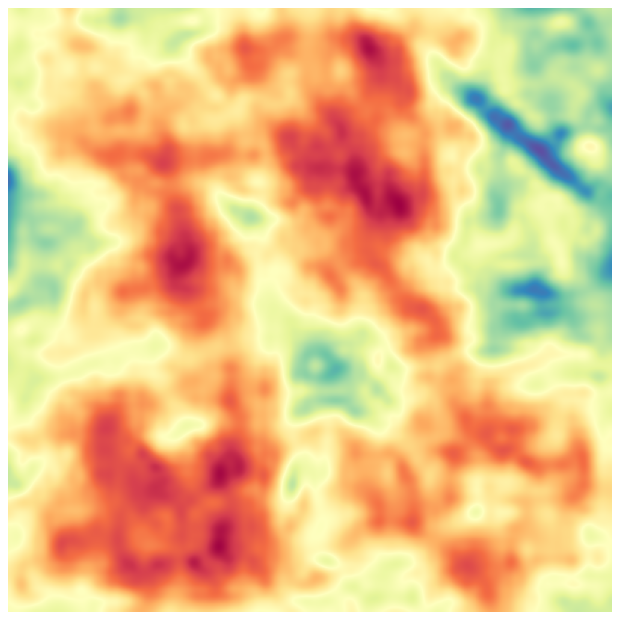

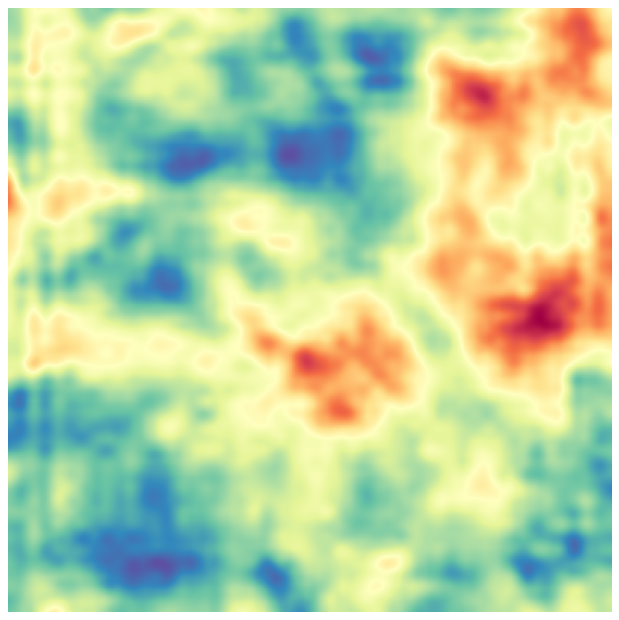

number of PCA : 27
5


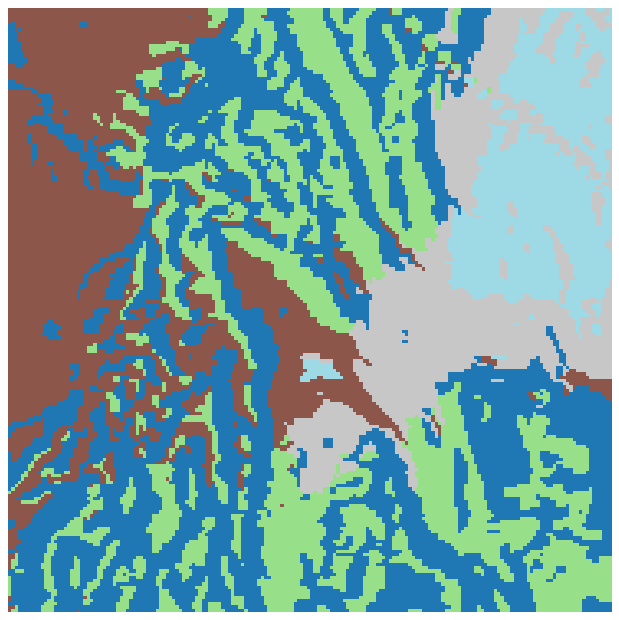

number of PCA : 27
6


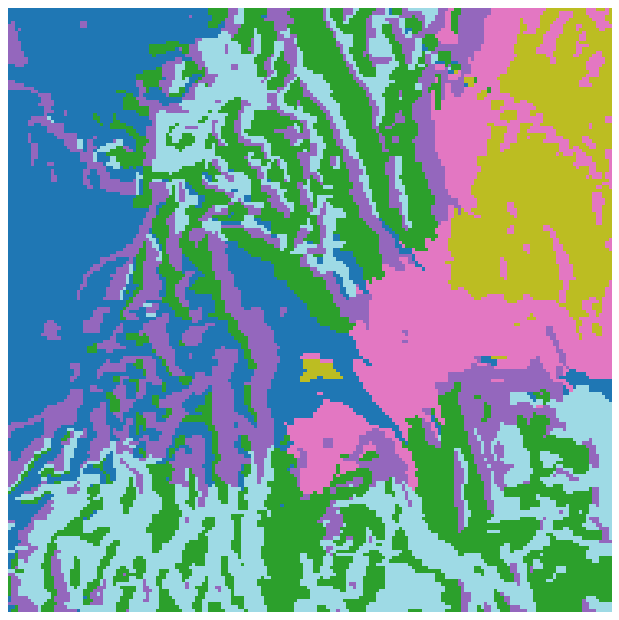

number of PCA : 27
7


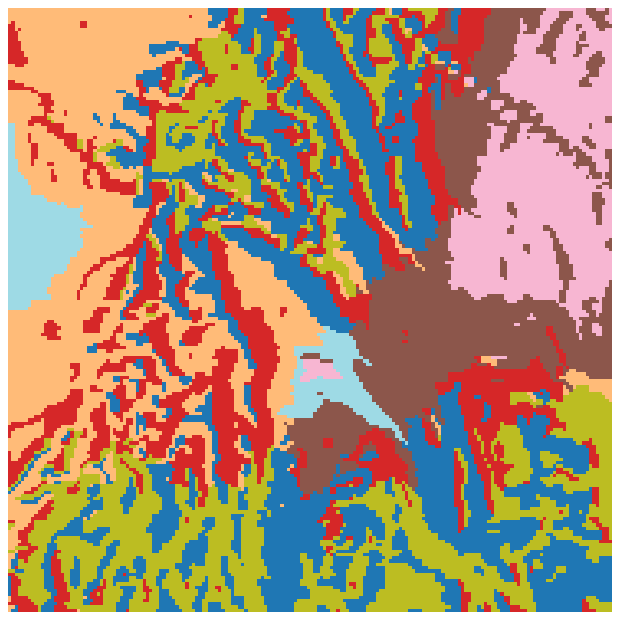

number of PCA : 27
8


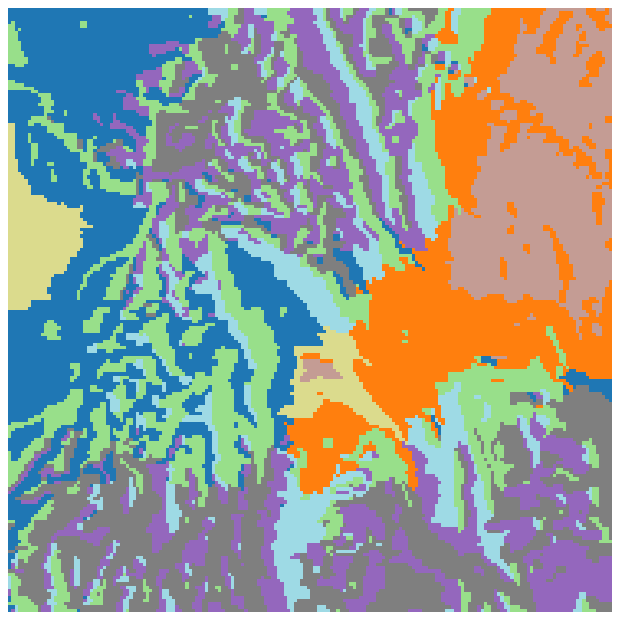

number of PCA : 27
9


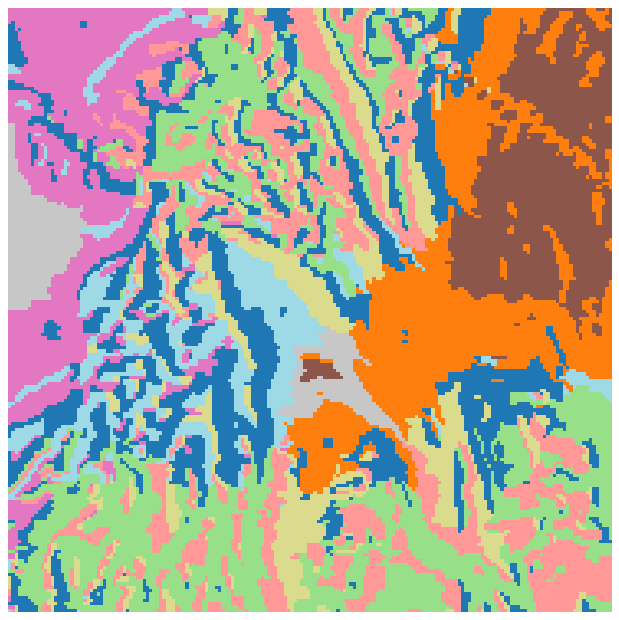

In [ ]:
#charger les donnéees de Grenville
path = '/content/gdrive/My Drive/mira_project/data_grenville.npy'  
data = np.load(path)
img = numpy_pil(data[160:560, 260:660], flip=True, norm=False) #on réduit la taille de l'image pour des résultats plus beau

mean_std = ([0.242, 0.242, 0.242], [0.156, 0.156, 0.156]) #mediane et écart type

#afficher les résultats 
plotting_all(img, mean_std)

#et les regroupement
data = transform_im(img, mean_std)
it_hclus(net, data, mini=5, maxi=10, res=1, lim=0.95, border =16)


#Autre Fonctions

Simplifier les géologies

/content/gdrive/My Drive/preprocessing/a_utils


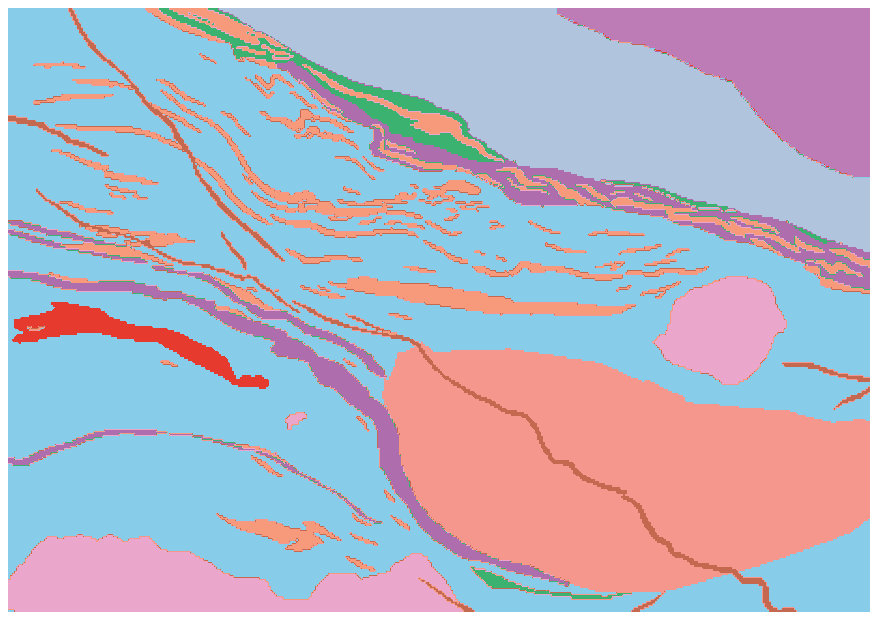

In [ ]:
%cd /content/gdrive/My Drive/preprocessing/a_utils

from b_load_data import open_3d_file
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  
import numpy as np

xx, yy, zz = 56, 401, 281
test = open_3d_file('../z_data/originals/1_dafull/lithos_2_1', xx, yy, zz)
test = np.moveaxis(test, [0,1,2], [0,2,1])[0]

test = np.load('../../mira_project/litho_original.npy')[:,:,0]
#print(test.shape)

#couleur RGB de la carte
colors = np.array([[176, 196, 222, 255], #1
                   [174, 110, 174, 255],#2
                   [60, 178, 112, 255],#3
                   [235, 167, 203, 255],#4
                   [247, 154, 123, 255],#5
                   [196,104,79, 255], #6
                   [246, 151, 141, 255],#7
                   [135, 205, 233, 255], #8
                   [230, 58, 46, 255],#9
                   [189, 124, 181, 255]])/255 #10

#image d'origine
newcmp = ListedColormap(colors)
plot_graphic(test, cmap = newcmp)

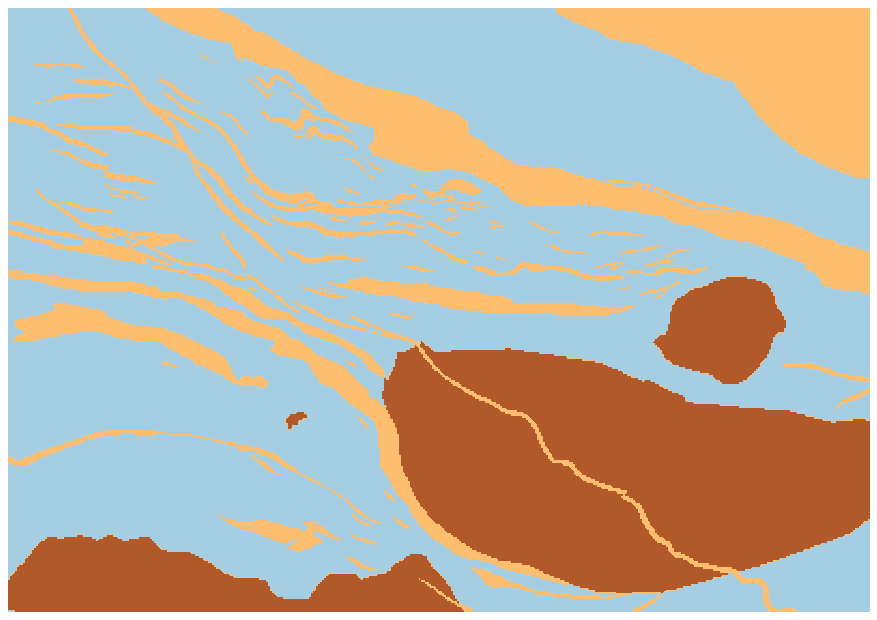

In [ ]:
#simplification des ithologies
plutons, greywackes, dykes = [4, 7], [1, 8], [2, 3, 6, 5, 9, 10]
lithologies =[greywackes, dykes, plutons]

#simplification des lithologies
a=20
for i in lithologies:
  for j in i:
    test = np.where(test==j, a, test)
  a+=1
test-=20

#afficher le résultat
cmap = cm.get_cmap("Paired", lut=3)
plot_graphic(test, cmap = cmap)

Résultas obtenus sur les données synthétiques

In [ ]:
%cd /content/gdrive/My Drive/preprocessing/a_utils

from b_load_data import open_2d_file, create_img

test = []
test += [create_img(open_2d_file('../z_data/originals/2_lithor/magfor_1_1_0_1.mag'))]
test += [create_img(open_2d_file('../z_data/originals/2_lithor/magfor_1_3_0_1.mag'))]
test += [create_img(open_2d_file('../z_data/originals/2_lithor/magfor_2_1_0_1.mag'))]
test += [create_img(open_2d_file('../z_data/originals/2_lithor/magfor_8_2_0_1.mag'))]

mean_std = ([0.157, 0.157, 0.157], [0.106, 0.106, 0.106])


for i in test:
  img = numpy_pil(i, flip=True)
  plotting_all(img, mean_std)
  data = transform_im(img, mean_std)
  it_hclus(net, data, mini=6, maxi=16, res=1, lim=0.95, border =16)


Output hidden; open in https://colab.research.google.com to view.

Afficher les représentations profondes

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


number of PCA : 11
original


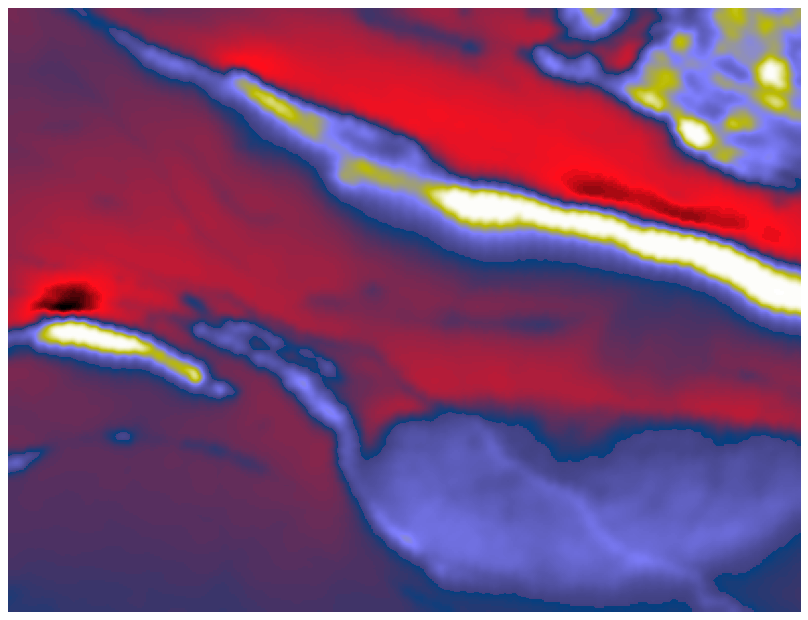

PCAs: 


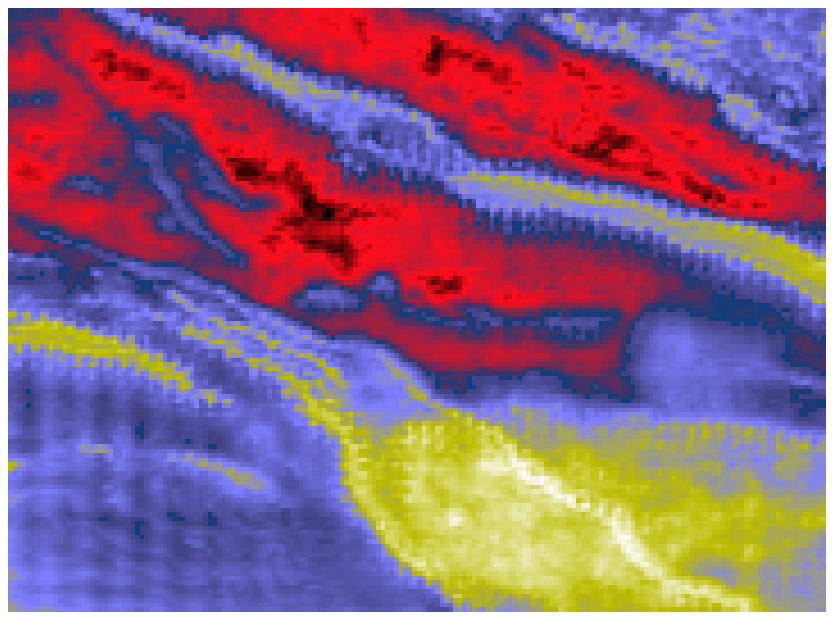

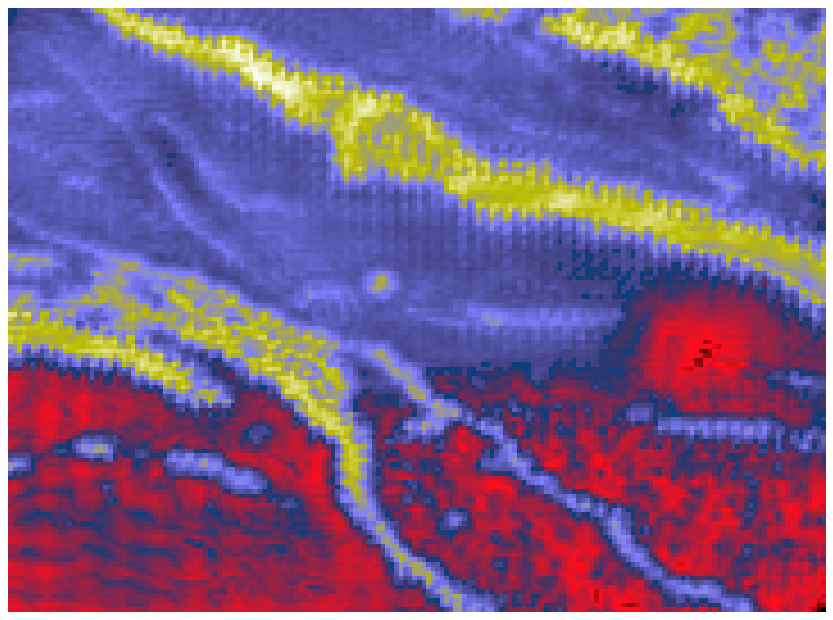

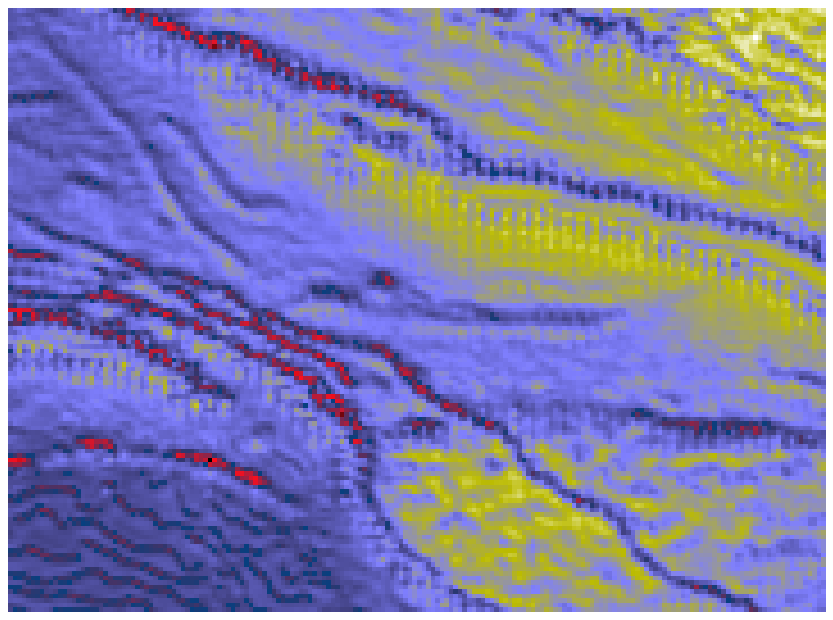

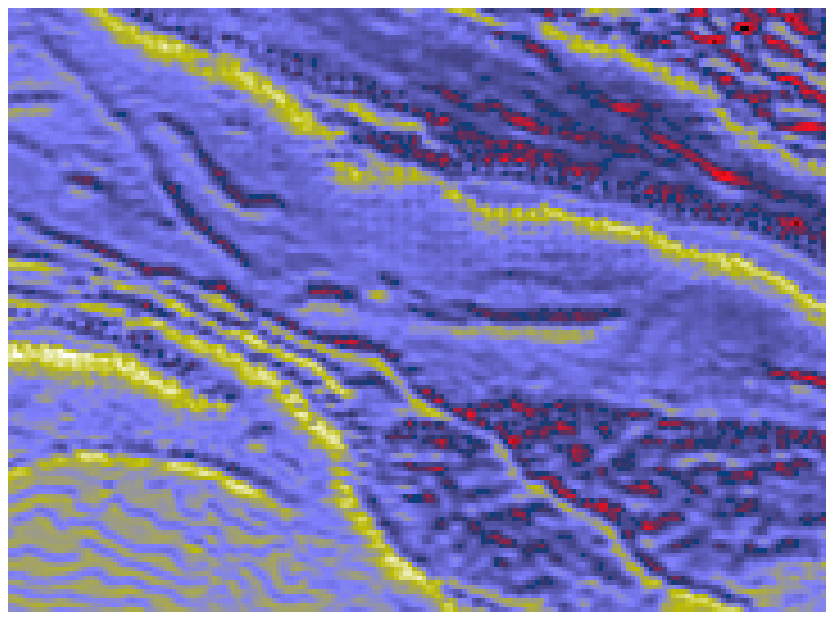

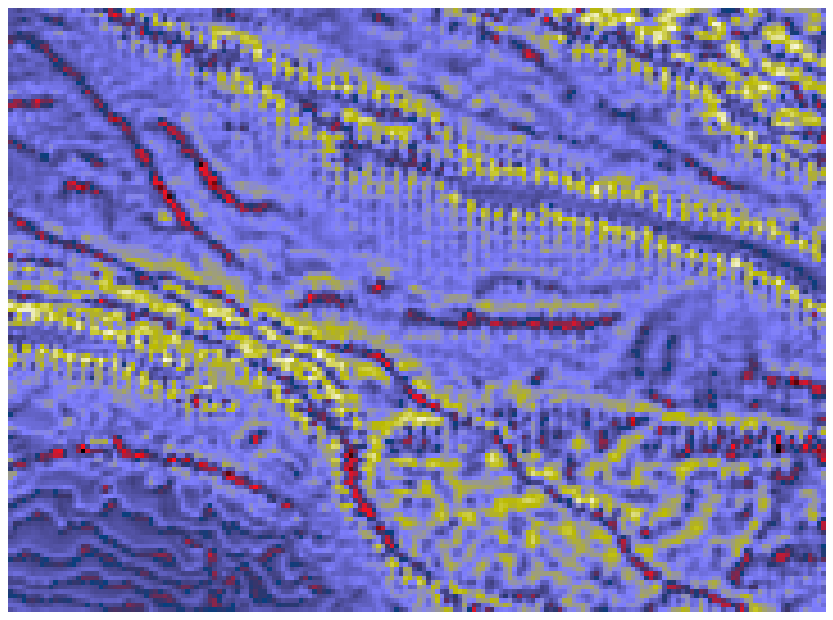

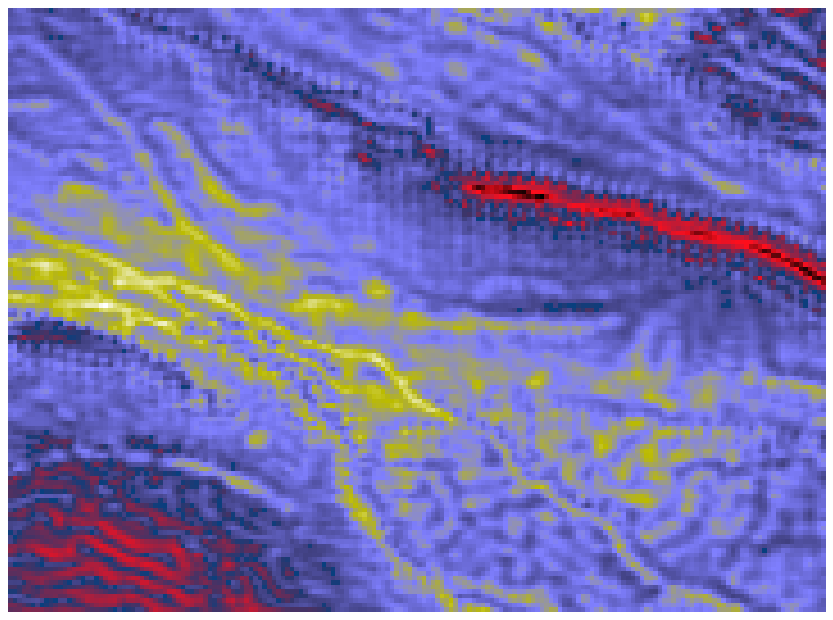

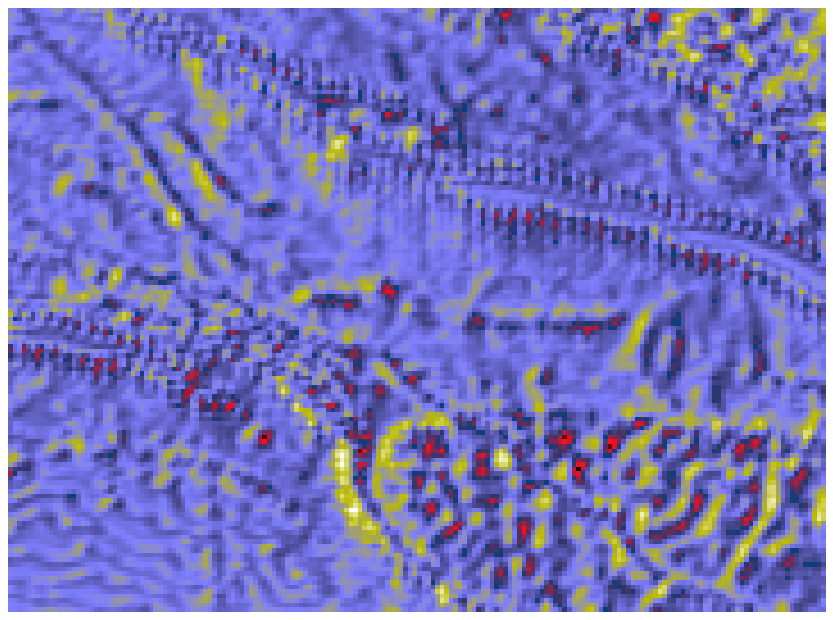

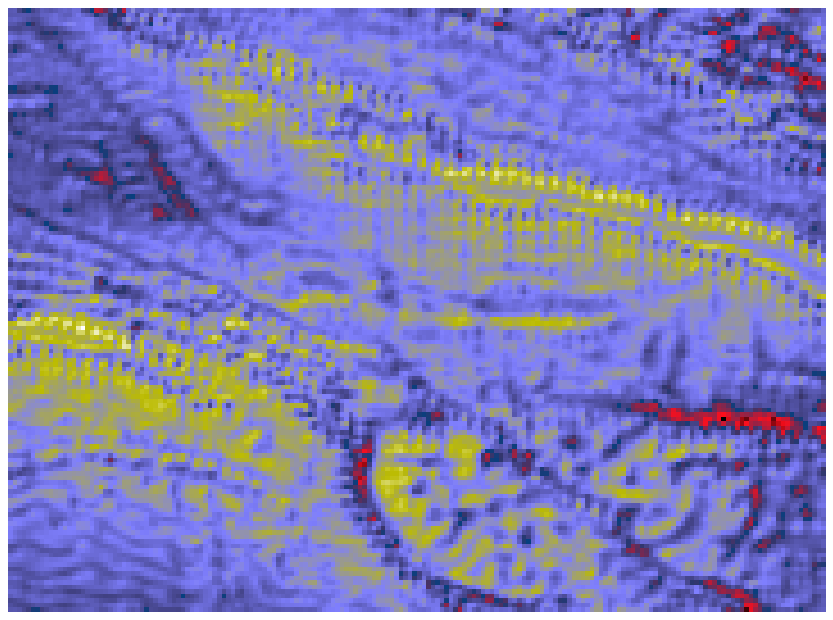

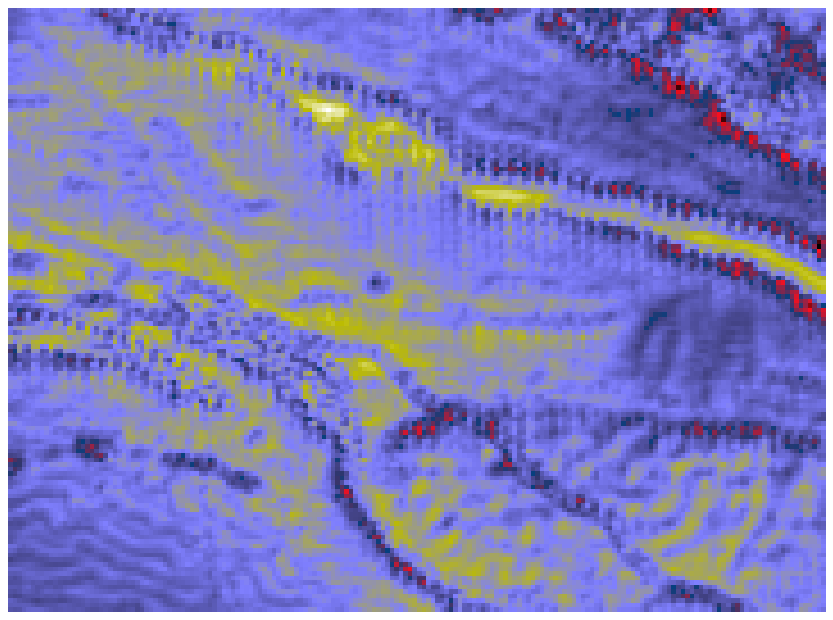

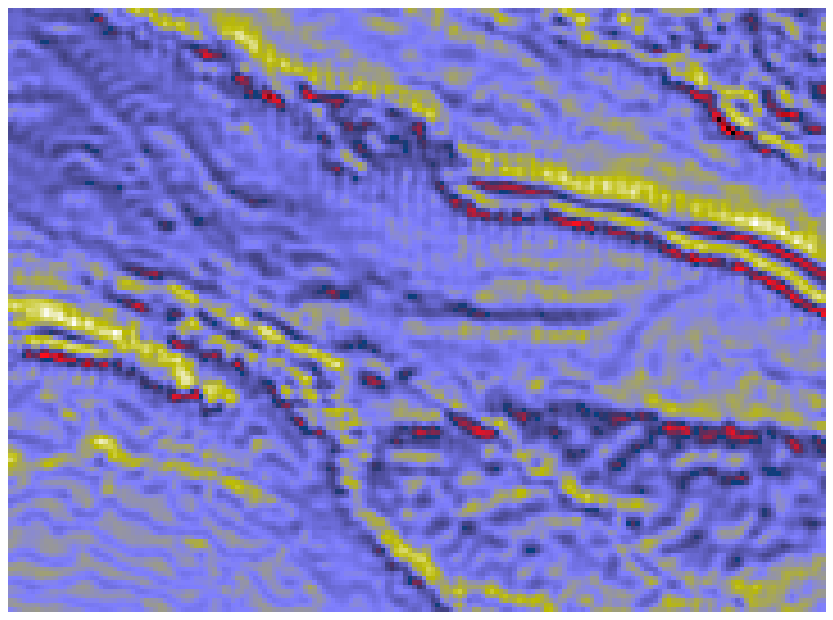

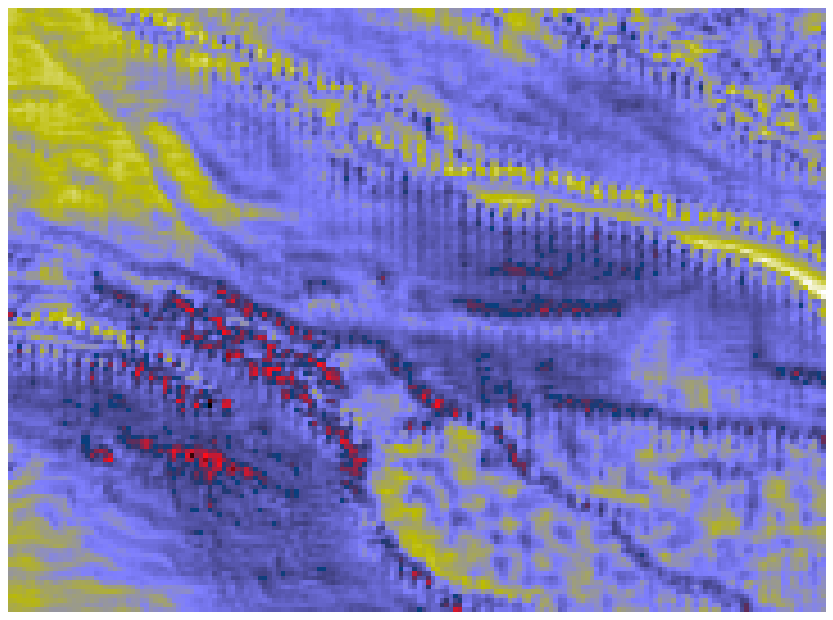

In [ ]:
import visualize

#normalisation 
vals, seg_out, edge_out = apply.aspp_output(net, data)
  
X, x, y = visualize.prepare_data2cluster(vals.cpu()[0], border=16, res=1)

#faire un PCA
X = visualize.calculate_pca(X, 0.8)
pcas = np.reshape(X, (x, y, 11))

print('original')
plot_graphic(data[0,0], cmap = 'gist_stern')

print('PCAs: ')
for i in range(pcas.shape[-1]):
  plot_graphic(pcas[:,:,i], cmap = 'gist_stern')

Calcul du IOU pour l'image d'origine seulement

In [ ]:
intersection = np.logical_and(test, data_seg)
union = np.logical_or(test, data_seg)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.5418010913291114
